### Importing the libraries

In [58]:
import numpy as np
import pandas as pd
from numpy import concatenate
import urllib.request as urllib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM


In [59]:
data = pd.read_csv("C:\\Users\\Udit Goel\\Desktop\\Files\\Projects\\ML DS\\Time Series\\Input\\PJME_hourly.csv",index_col=[0], parse_dates=[0])
data.head()


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [60]:
data.shape

(145366, 1)

### Plotting the data over the timline for energy consumption

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


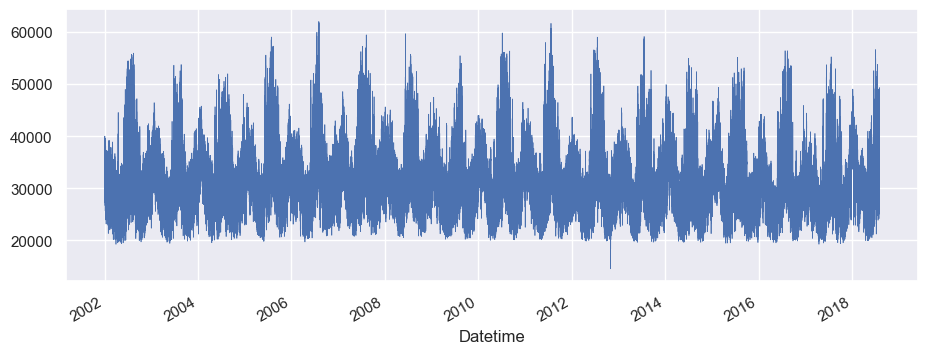

In [61]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
data['PJME_MW'].plot(linewidth=0.5);
data

In [62]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['Week_Number'] = df['date'].dt.isocalendar().week

    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='PJME_MW')

df = pd.concat([X, y], axis=1)
df.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


In [63]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	#if dropnan:
		#agg.dropna(inplace=True)
	return agg
 

In [64]:
# Preprocess data
labelEncoder = LabelEncoder()
oneHotEncoder = OneHotEncoder(categories=[0])
ss = StandardScaler()

values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,8] = encoder.fit_transform(values[:,8])
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())



(145366, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1   0.043478   0.166667        1.0        1.0        0.0    0.99726   
2   0.086957   0.166667        1.0        1.0        0.0    0.99726   
3   0.130435   0.166667        1.0        1.0        0.0    0.99726   
4   0.173913   0.166667        1.0        1.0        0.0    0.99726   

   var7(t-1)  var8(t-1)  var9(t-1)   var9(t)  
0        NaN        NaN        NaN  0.221308  
1        1.0        0.0   0.221308  0.173875  
2        1.0        0.0   0.173875  0.153727  
3        1.0        0.0   0.153727  0.147363  
4        1.0        0.0   0.147363  0.163783  


In [65]:
# Preprocess data
labelEncoder = LabelEncoder()
oneHotEncoder = OneHotEncoder(categories=[0])
ss = StandardScaler()

values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,8] = encoder.fit_transform(values[:,8])
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


df

(145366, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1   0.043478   0.166667        1.0        1.0        0.0    0.99726   
2   0.086957   0.166667        1.0        1.0        0.0    0.99726   
3   0.130435   0.166667        1.0        1.0        0.0    0.99726   
4   0.173913   0.166667        1.0        1.0        0.0    0.99726   

   var7(t-1)  var8(t-1)  var9(t-1)   var9(t)  
0        NaN        NaN        NaN  0.221308  
1        1.0        0.0   0.221308  0.173875  
2        1.0        0.0   0.173875  0.153727  
3        1.0        0.0   0.153727  0.147363  
4        1.0        0.0   0.147363  0.163783  


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,42402.0


In [66]:
# split into train and test sets
reframed['date_time'] = df.index.values
split_date = '01-Jan-2015'

train = reframed.loc[reframed['date_time']<=split_date].drop(['date_time'],axis=1).dropna().values
test = reframed.loc[reframed['date_time']>split_date].drop(['date_time'],axis=1).dropna().values

# split into input and output
X_train, y_train = train[:, 0:-1], train[:, -1]
X_test, y_test = test[:, 0:-1], test[:, -1]

In [67]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(113926, 1, 9) (113926,) (31439, 1, 9) (31439,)


### Training and running the model 

In [68]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
##model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/10
1628/1628 - 4s - loss: 0.0671 - val_loss: 0.0423 - 4s/epoch - 3ms/step
Epoch 2/10
1628/1628 - 3s - loss: 0.0405 - val_loss: 0.0336 - 3s/epoch - 2ms/step
Epoch 3/10
1628/1628 - 3s - loss: 0.0361 - val_loss: 0.0324 - 3s/epoch - 2ms/step
Epoch 4/10
1628/1628 - 3s - loss: 0.0342 - val_loss: 0.0329 - 3s/epoch - 2ms/step
Epoch 5/10
1628/1628 - 3s - loss: 0.0331 - val_loss: 0.0323 - 3s/epoch - 2ms/step
Epoch 6/10
1628/1628 - 4s - loss: 0.0325 - val_loss: 0.0332 - 4s/epoch - 2ms/step
Epoch 7/10
1628/1628 - 4s - loss: 0.0320 - val_loss: 0.0344 - 4s/epoch - 2ms/step
Epoch 8/10
1628/1628 - 5s - loss: 0.0316 - val_loss: 0.0392 - 5s/epoch - 3ms/step
Epoch 9/10
1628/1628 - 5s - loss: 0.0314 - val_loss: 0.0374 - 5s/epoch - 3ms/step
Epoch 10/10
1628/1628 - 5s - loss: 0.0312 - val_loss: 0.0386 - 5s/epoch - 3ms/step


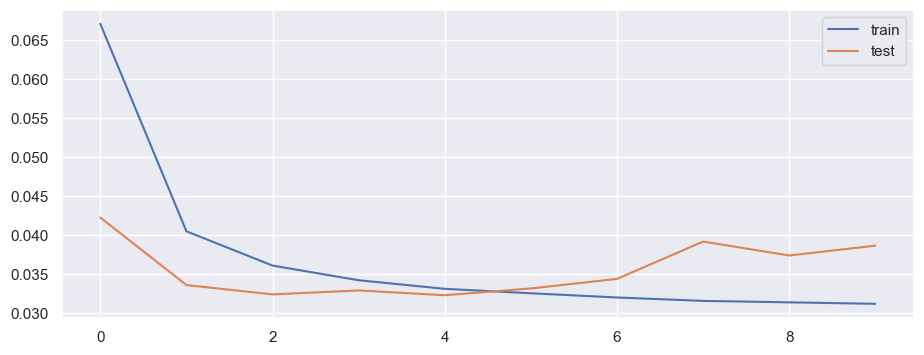

In [69]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Making a prediction using the training the data

In [70]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

983/983 [==============================] - 2s 986us/step


In [71]:
# invert scaling for forecast
inv_yhat = concatenate((X_test[:,:-1],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test[:,:-1],y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


In [72]:
# calculate RMSE
MSE=mean_squared_error(inv_y,inv_yhat)
MAE=mean_absolute_error(inv_y,inv_yhat)
RMSE = sqrt(mean_squared_error(inv_y, inv_yhat))
print('MSE: %.3f' % MSE + '   MAE: %.3f' % MAE + '   RMSE: %.3f' % RMSE)

MSE: 1976852.546   MAE: 1099.152   RMSE: 1406.006


In [73]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(inv_y,inv_yhat))
print(f" The R2 accuracy for the model is : {r2_score(inv_y,inv_yhat)}")

25.694598958815334
 The R2 accuracy for the model is : 0.9477845931234737


### Plotting the prediciton for energy consumption over graph

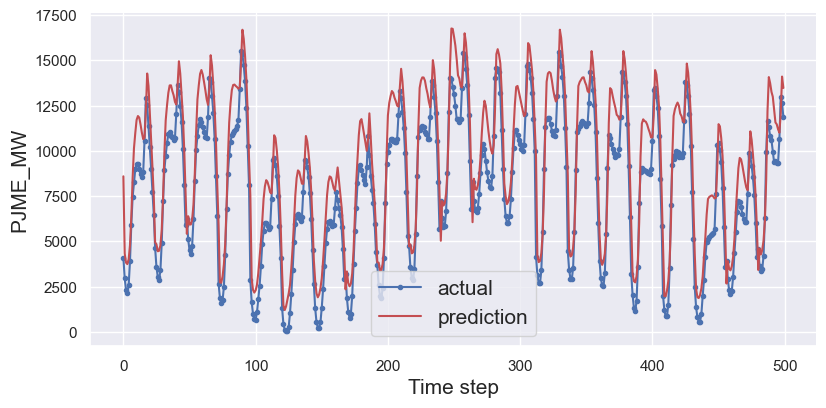

In [74]:
aa=[x for x in range(500)]
plt.figure(figsize=(8,4))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PJME_MW', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();